### **Begin Reading in data**

In [344]:
from os import getcwd
from os.path import join

import pandas as pd
import numpy as np
from dateutil.parser import parse
from enum import Enum, unique
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from copy import deepcopy
from scipy import stats


In [345]:
cwd = getcwd()
filename = "crypto_data_set.csv"
filepath = join(cwd, filename)
num_market_instruments = 3

In [346]:
DF = pd.DataFrame

# **Cleaning Data**

In [347]:
def read_data(filepath):
    try:
        _data = pd.read_csv(filepath)
    except Exception:
        raise Exception('Cannot read csv file at path {}'.format(filepath))
    return _data

In [348]:
def refactor_headers(data):
    columns = list(data.columns)
    data['Dates'] = data['Dates'].apply(parse)
    data.set_index(columns[0], inplace=True)
    data = data.apply(pd.to_numeric, errors='coerce')
    return data

In [349]:
def drop_all_nan_rows(prices, volumes):
    ind = list(prices.iloc[:, 1:].dropna(how='all').index)
    prices = refactor_headers(prices.loc[ind])
    volumes = refactor_headers(volumes.loc[ind])
    return prices, volumes

In [350]:
def clean_data(data):
    columns = list(data.columns)
    column_of_prices = columns[:1] + columns[1:-1:2]
    column_of_volume = columns[:1] + list(set(columns) - set(column_of_prices))
    data = data.iloc[1:]
    data = data[::-1].reset_index(drop=True)
    prices = data.loc[:, data.columns.isin(column_of_prices)]
    volumes = data.loc[:, data.columns.isin(column_of_volume)]
    volumes.columns = column_of_prices

    market_prices = pd.concat([prices.iloc[:, 0], prices.iloc[:, -num_market_instruments:]], axis=1)
    market_volumes = pd.concat([volumes.iloc[:, 0], volumes.iloc[:, -num_market_instruments:]], axis=1)

    crypto_prices = prices.iloc[:, :-num_market_instruments]
    crypto_volumes = volumes.iloc[:, :-num_market_instruments]

    crypto_prices, crypto_volumes = drop_all_nan_rows(crypto_prices, crypto_volumes)
    market_prices, market_volumes = drop_all_nan_rows(market_prices, market_volumes)

    return crypto_prices, crypto_volumes, market_prices, market_volumes

In [351]:
data = read_data(filepath)

In [352]:
crypto_prices, crypto_volumes, market_prices, market_volumes = clean_data(data)

In [353]:
crypto_prices.head(3)

,BTC1 Curncy,DCR1 Curncy,BGCI Index,XBT Curncy,XET Curncy,XBI Curncy,XRP Curncy,XAD Curncy,XSO Curncy,XDG Curncy
Dates,,,,,,,,,,
2010-07-19,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-20,NaN,NaN,NaN,0.07,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-21,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,NaN


# Dropping several coins due to limited data history

Including all the crypto coins would result in less that 9 months of pricing data after cleaning the data

In [354]:
#columns_to_drop = ['XDG Curncy', 'XSO Curncy', 'XAD Curncy']
columns_to_drop = ['XDG Curncy', 'XSO Curncy', 'XAD Curncy', 'DCR1 Curncy']

In [355]:
def drop_columns(df, columns_to_drop):
    df.drop(columns_to_drop, inplace=True, axis=1)
    df = df.dropna(how='all')
    df = df[df.isnull().sum(axis=1) < 1]
    return df

In [356]:
crypto_prices = drop_columns(crypto_prices, columns_to_drop)

In [357]:
crypto_prices.head(3)

,BTC1 Curncy,BGCI Index,XBT Curncy,XET Curncy,XBI Curncy,XRP Curncy
Dates,,,,,,
2018-12-21,8785.0,254.02,3848.6,108.023,5.5972,0.3565
2018-12-24,9080.0,288.95,3848.6,142.230,6.3138,0.4097
2018-12-25,9080.0,288.95,3848.6,130.060,5.6763,0.3811


In [358]:
def calculate_returns(data) -> DF:
    data = data.pct_change(periods=1, fill_method='pad')
    data.replace([np.NaN, np.nan, np.inf, -np.inf, -1], 0, inplace=True)
    return data

In [359]:
def calculate_cumulative_returns(returns):
    return (1 + returns).cumprod() - 1

In [360]:
crypto_returns = calculate_returns(crypto_prices)

In [361]:
market_returns = calculate_returns(market_prices)

In [362]:
cum_market_returns = calculate_cumulative_returns(market_returns)

In [363]:
cum_crypto_returns = calculate_cumulative_returns(crypto_returns)

In [364]:
def plot(returns, title, y_label, x_label='Date'):
    fig, ax = plt.subplots(figsize=(18, 8))

    for i in returns.columns.values:
        ax.plot(returns[i], lw=2, label=i)

    ax.legend(loc='upper left', fontsize=10)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show(fig)

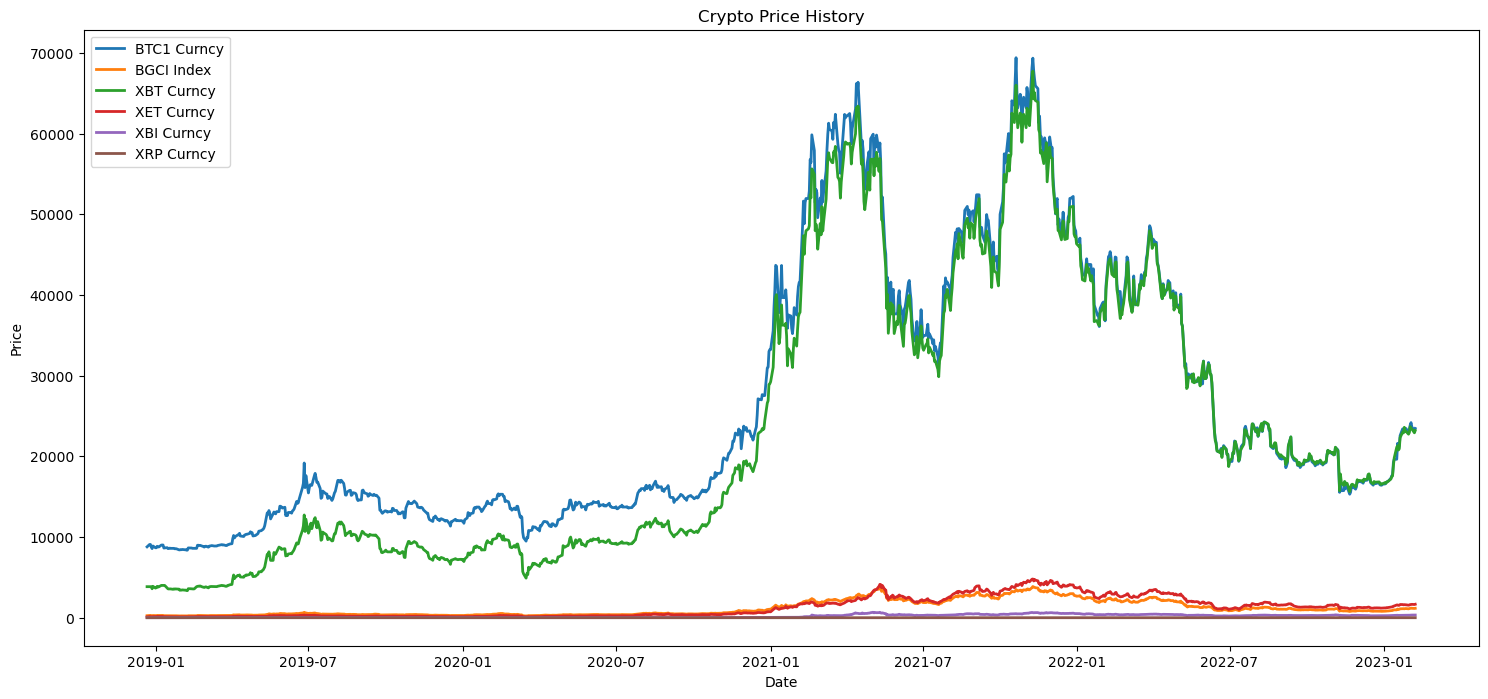

In [365]:
# Visualize crypto coin prices
plot(crypto_prices, title='Crypto Price History', y_label='Price')

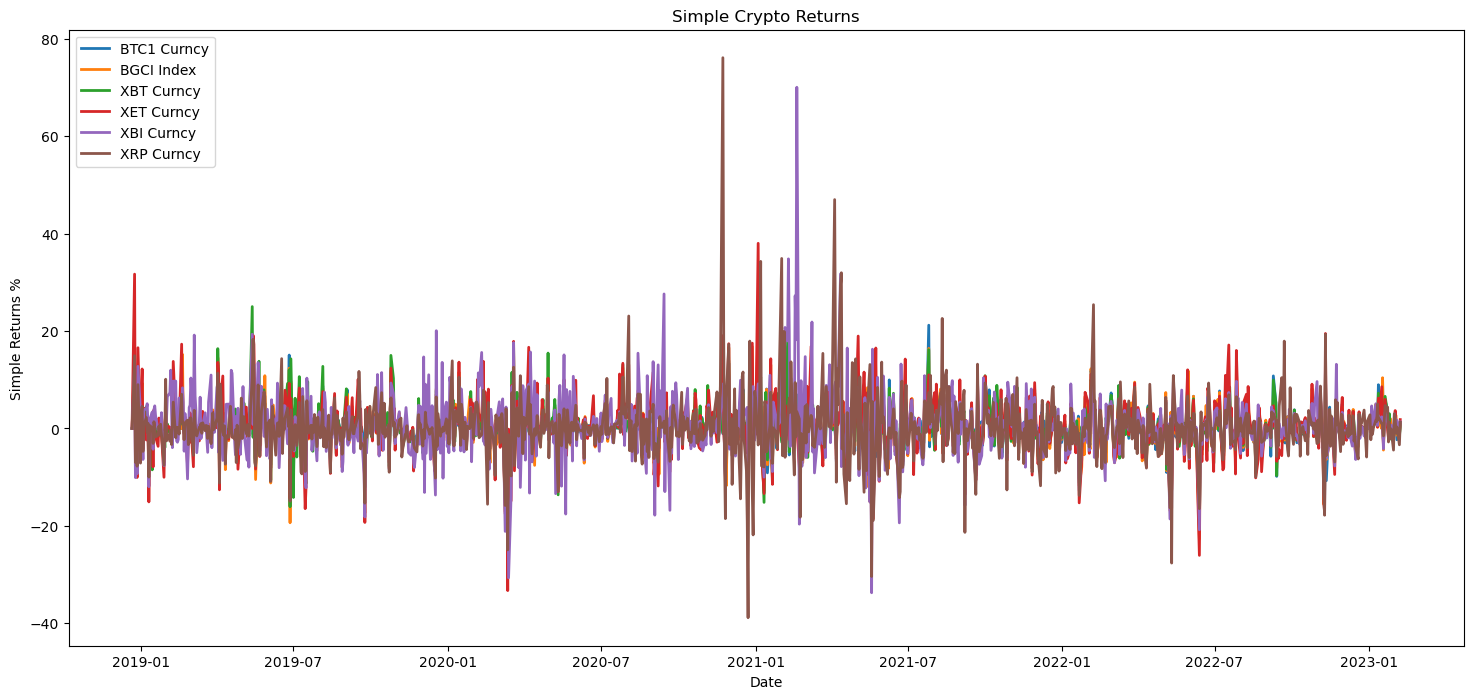

In [366]:
# Visualize crypto coin simple returns
plot(crypto_returns * 100, title='Simple Crypto Returns', y_label='Simple Returns %')

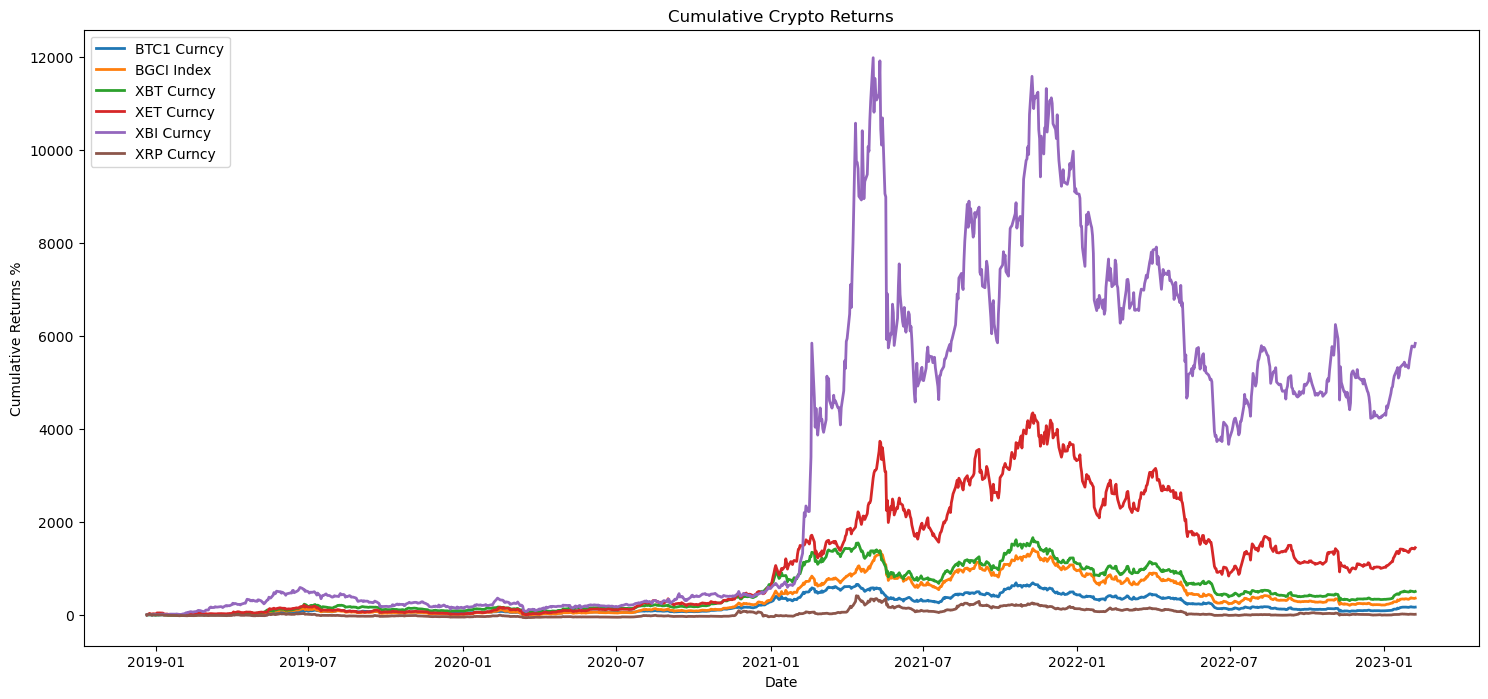

In [367]:
# Visualize crypto coin cumulative returns
plot(cum_crypto_returns*100, title='Cumulative Crypto Returns', y_label='Cumulative Returns %')

In [368]:
crypto_correlation = crypto_returns.corr(method='pearson')

In [369]:
crypto_correlation

,BTC1 Curncy,BGCI Index,XBT Curncy,XET Curncy,XBI Curncy,XRP Curncy
BTC1 Curncy,1.000000,0.891610,0.896775,0.709377,0.498223,0.485267
BGCI Index,0.891610,1.000000,0.832847,0.874943,0.551906,0.617149
XBT Curncy,0.896775,0.832847,1.000000,0.760234,0.530657,0.543204
XET Curncy,0.709377,0.874943,0.760234,1.000000,0.544338,0.593275
XBI Curncy,0.498223,0.551906,0.530657,0.544338,1.000000,0.453074
XRP Curncy,0.485267,0.617149,0.543204,0.593275,0.453074,1.000000


We see moderate to strong correlation between the coins based only on the correlation coefficient some of which are expected as bitcoin and etherium have the largest weights in the BGCI Index

In [370]:
crypto_cov = crypto_returns.cov()

In [371]:
crypto_cov

,BTC1 Curncy,BGCI Index,XBT Curncy,XET Curncy,XBI Curncy,XRP Curncy
BTC1 Curncy,0.001375,0.001561,0.001428,0.001472,0.001194,0.001172
BGCI Index,0.001561,0.002230,0.001689,0.002312,0.001685,0.001898
XBT Curncy,0.001428,0.001689,0.001843,0.001827,0.001473,0.001519
XET Curncy,0.001472,0.002312,0.001827,0.003132,0.001969,0.002163
XBI Curncy,0.001194,0.001685,0.001473,0.001969,0.004178,0.001908
XRP Curncy,0.001172,0.001898,0.001519,0.002163,0.001908,0.004243


In [372]:
def run_pca(data):
    columns = list(data.columns)
    x = StandardScaler().fit_transform(data)
    pca = PCA()
    principal_components = pca.fit_transform(x)
    principal_df = pd.DataFrame(data=pca.components_, columns=columns)
    var_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=range(pca.n_components_))
    return principal_df, var_ratio

In [373]:
principal_df, var_ratio = run_pca(crypto_returns)

In [221]:
var_ratio

,0,1,2,3,4,5
0,0.719536,0.108283,0.092172,0.049871,0.023926,0.006212


The first principal component captures over 71% of the variance in the data. This together with the principal component table below shows that the prices of multiple coins move together. As most of the components are below 0.5 for all the coins, predicting prices using other coins would lead to errors

In [374]:
principal_df

,BTC1 Curncy,BGCI Index,XBT Curncy,XET Curncy,XBI Curncy,XRP Curncy
0,-0.433147,-0.458281,-0.439173,-0.429303,-0.328745,-0.342221
1,-0.401367,-0.182146,-0.289146,-0.036686,0.656330,0.538522
2,-0.121949,0.053098,-0.075221,0.089794,-0.675348,0.715887
3,-0.388422,0.200023,-0.335293,0.786329,-0.061716,-0.273084
4,-0.361503,-0.545223,0.710634,0.256249,-0.035251,-0.011868
5,-0.595702,0.645527,0.316925,-0.349734,-0.003292,-0.075294


# Examining the distribution of coin vs market prices

<Axes: title={'center': 'Simple Returns Box Plot'}>

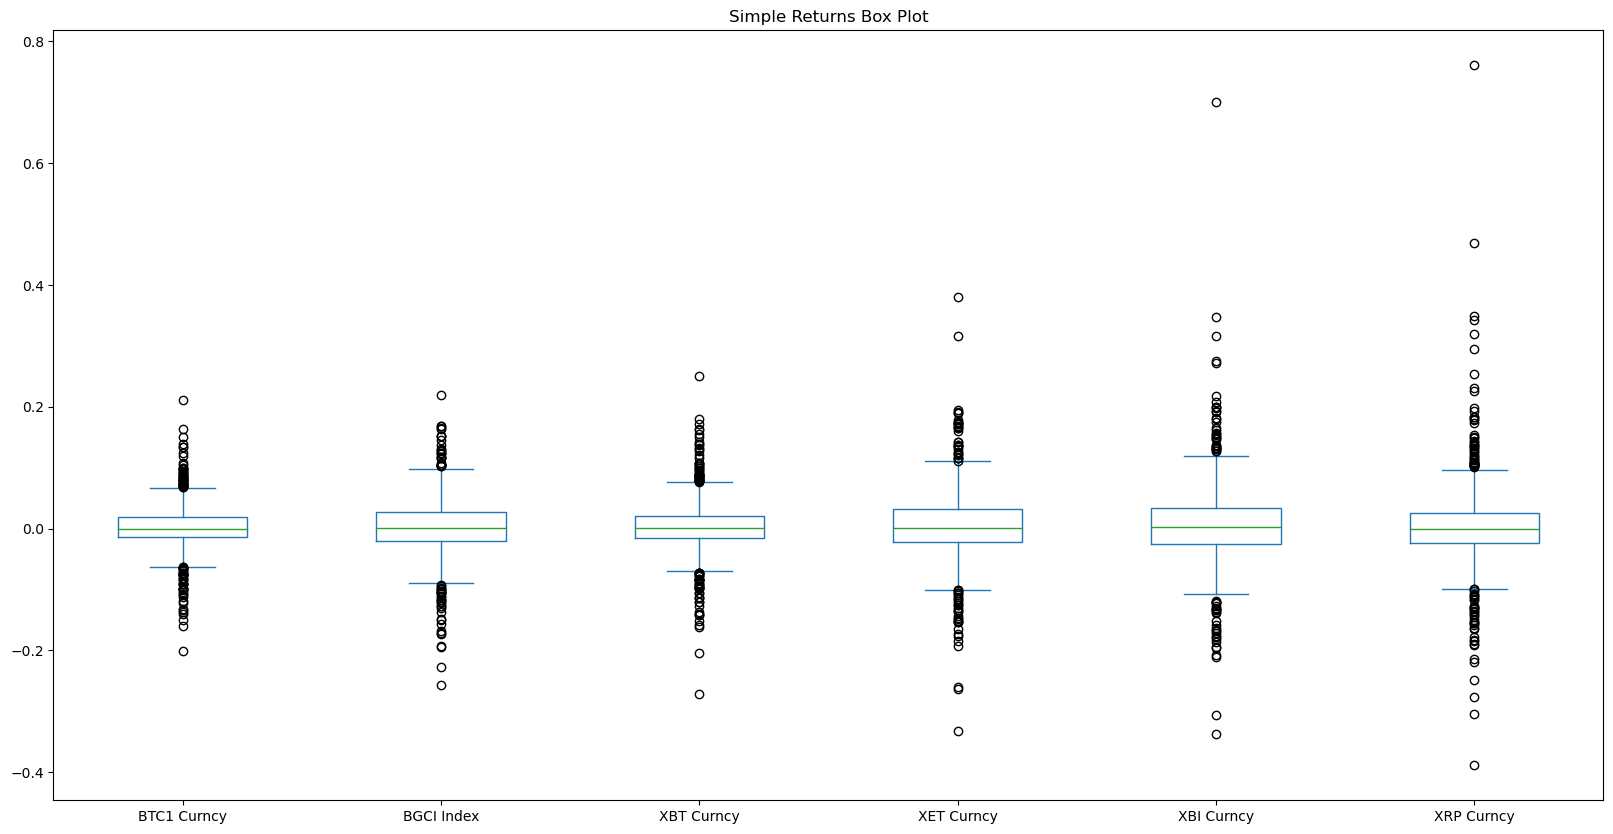

In [376]:
crypto_returns.plot(kind = "box",figsize = (20,10), title = "Simple Returns Box Plot")

<Axes: title={'center': 'Cumulative Returns Box Plot'}>

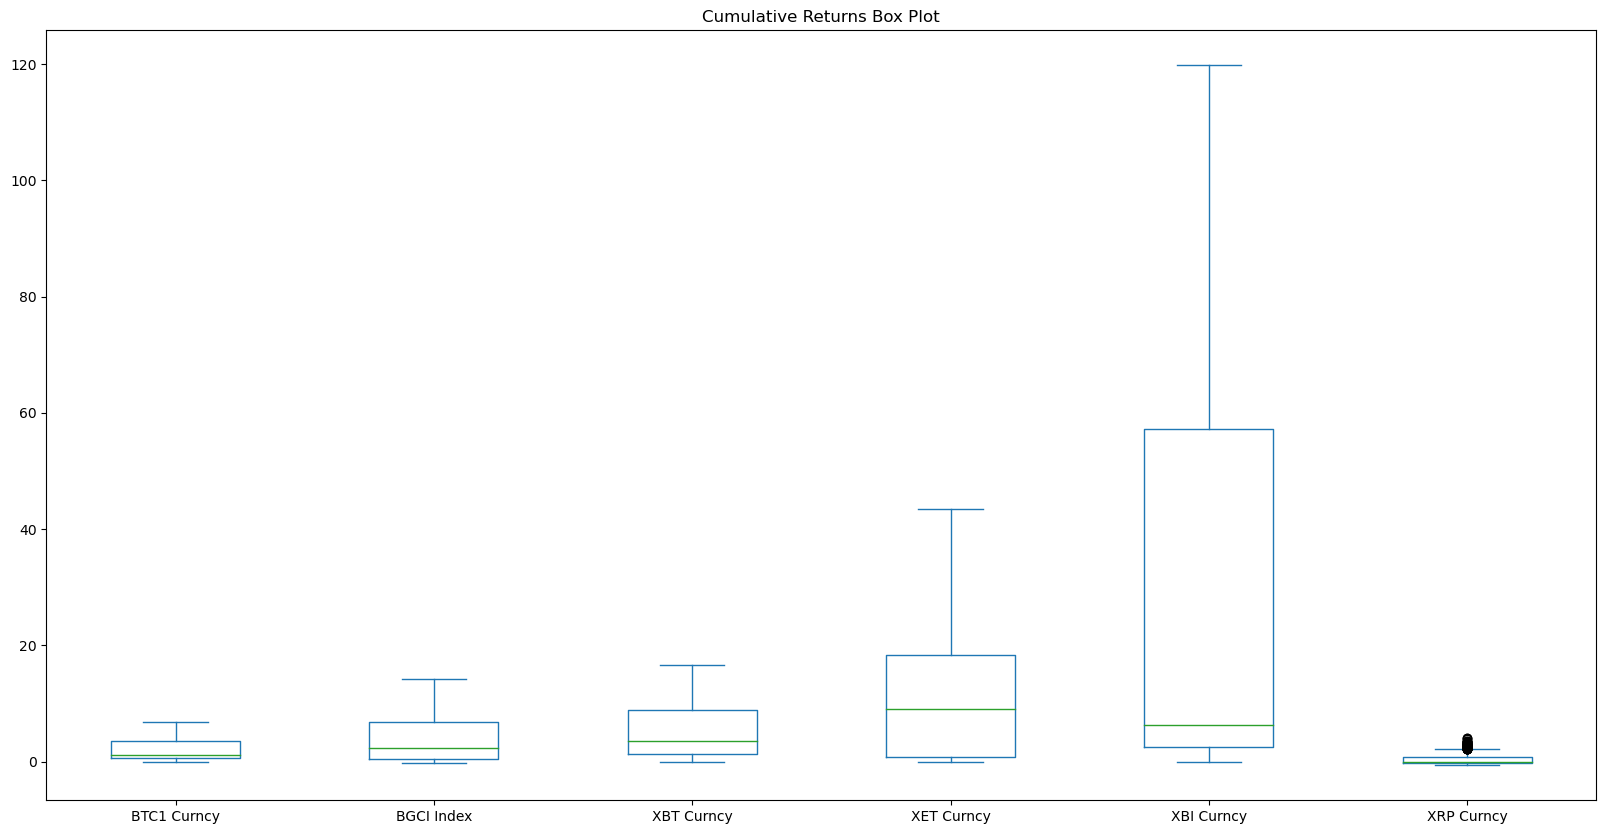

In [377]:
cum_crypto_returns.plot(kind = "box",figsize = (20,10), title = "Cumulative Returns Box Plot")

In [378]:
crypto_returns.skew()

BTC1 Curncy   -0.027333
BGCI Index    -0.272682
XBT Curncy    -0.029279
XET Curncy     0.165040
XBI Curncy     1.292464
XRP Curncy     1.896928
dtype: float64

In [379]:
market_returns.skew()

SPXT Index   -0.491087
XNDX Index   -0.340306
GC1 Comdty   -0.492166
dtype: float64

In [380]:
crypto_returns.kurtosis()

BTC1 Curncy     4.087608
BGCI Index      3.315578
XBT Curncy      4.809505
XET Curncy      5.626544
XBI Curncy     15.314392
XRP Curncy     23.798925
dtype: float64

In [381]:
market_returns.kurtosis()

SPXT Index    12.738349
XNDX Index     7.047123
GC1 Comdty     5.945911
dtype: float64

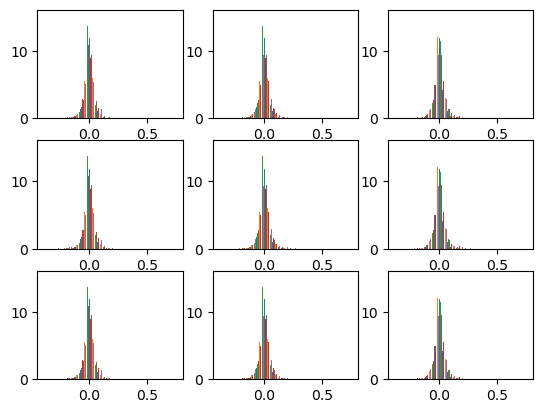

In [383]:
fig, a = plt.subplots(3, 3)
a = a.ravel()
for idx, ax in enumerate(a):
    ax.hist(crypto_returns, bins=50, density=True)
plt.show(fig)

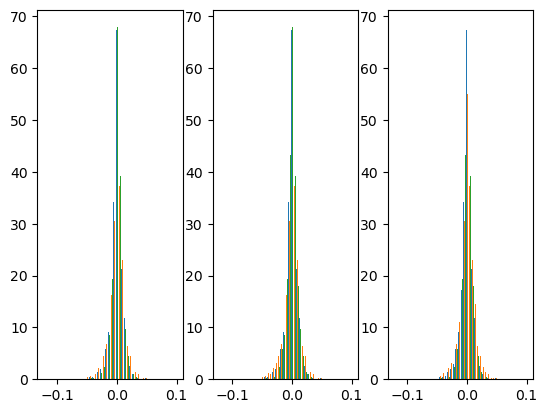

In [384]:
fig, a = plt.subplots(1, 3)
a = a.ravel()
for idx, ax in enumerate(a):
    ax.hist(market_returns, bins=50, density=True)
plt.show(fig)

In [385]:
res = stats.normaltest(crypto_returns)
res.statistic

array([106.6697331 , 101.58217304, 121.83072758, 142.02141755,
       435.78103352, 604.24380409])

In [386]:
dist = stats.chi2(df=2)
pvalues = dist.sf(res.statistic)
print(pvalues)

[6.87007951e-024 8.74402507e-023 3.50585252e-027 1.44690835e-031
 2.35153211e-095 6.16772610e-132]


In [387]:
res = stats.normaltest(market_returns)
res.statistic

array([812.75042384, 550.77304985, 558.49411744])

In [388]:
dist = stats.chi2(df=2)
pvalues = dist.sf(res.statistic)
print(pvalues)

[3.26202948e-177 2.51855729e-120 5.30326477e-122]


We see similarities in the skew and kurtosis of various crypto coins to the different market instruments. It is worth nothing that the distributions for the coins are very different from each other with the size of the tail varying significantly. Whilst the returns are larger in the crypto currencies, I do not think they are better investments from a risk perspective as the volatility, drawdown and cvar are much larger than the market instruments

In [393]:
def calculate_vol(df, window, period):
    df = df.rolling(window=window).apply(np.std) * np.sqrt(period)
    df = df.replace([np.inf], np.NaN)
    df.dropna(inplace=True)
    return df

In [394]:
# Monthly volatility
vol = calculate_vol(crypto_returns, 252, 20)

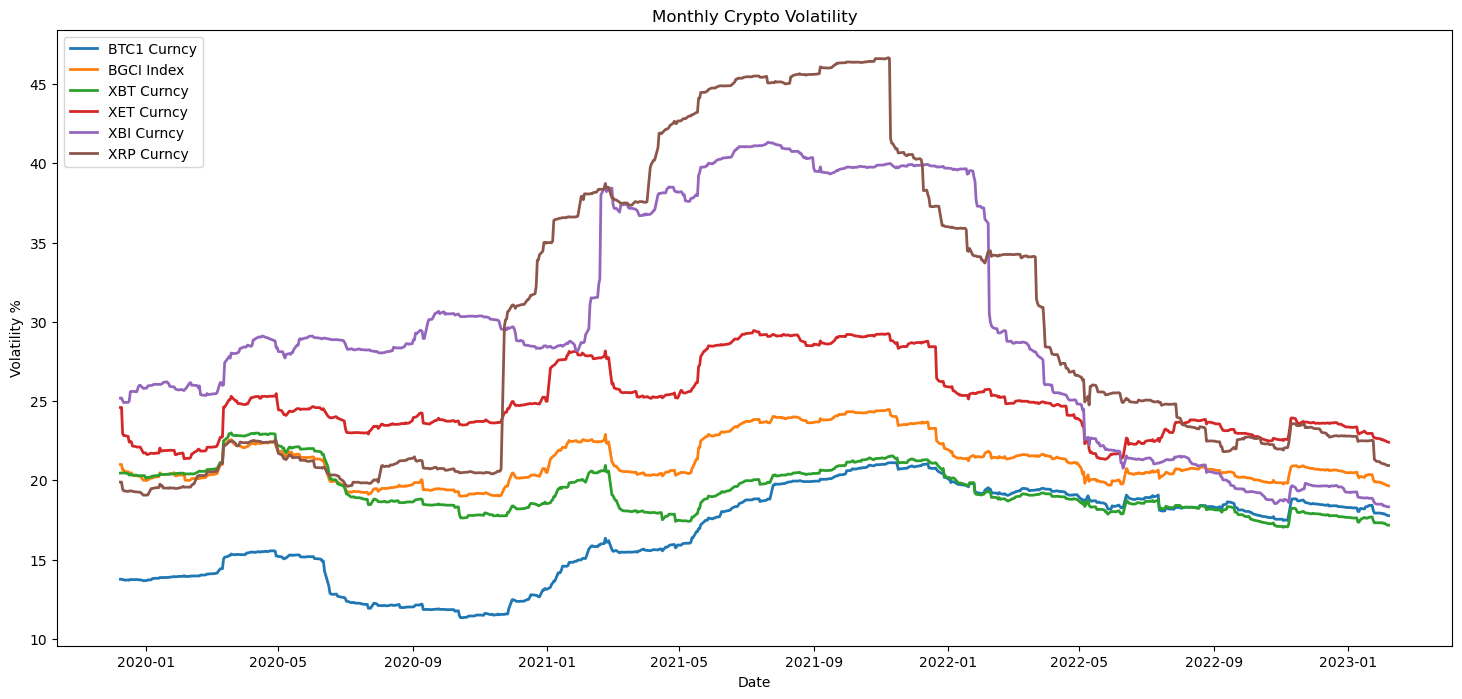

In [395]:
plot(vol*100, title='Monthly Crypto Volatility', y_label='Volatility %')

In [396]:
# Monthly volatility for non crypto investments
vol = calculate_vol(market_returns, 252, 20)

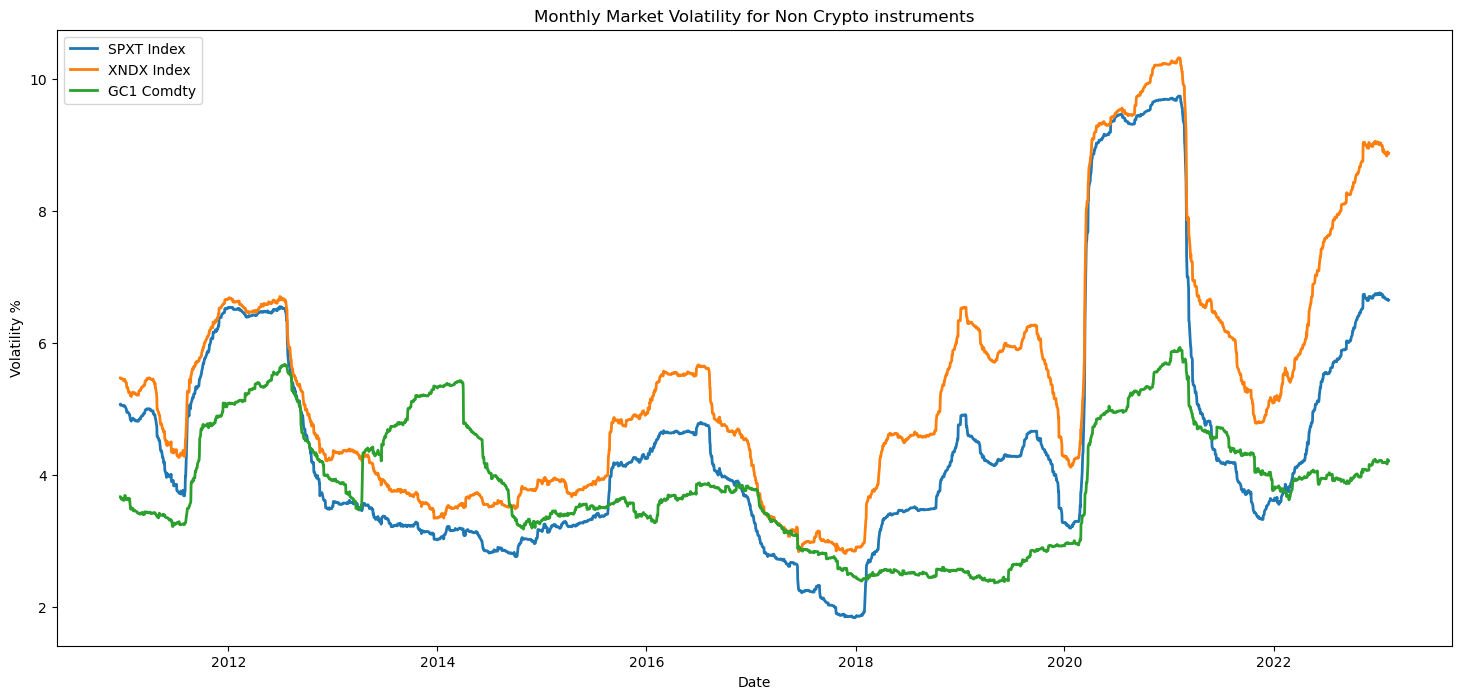

In [397]:
plot(vol*100, title='Monthly Market Volatility for Non Crypto instruments', y_label='Volatility %')

In [398]:
def calculate_sharpe_ratio(returns, period=1):
    sharpe = np.sqrt(period) * (returns.mean() / returns.std(ddof=1))
    return sharpe

In [399]:
def calculate_rolling_parameter(returns, window, param_func):
    parameter = returns.rolling(window=window).apply(param_func)
    return parameter

In [400]:
rolling_sharpe_ratio = calculate_rolling_parameter(crypto_returns, 20, calculate_sharpe_ratio)

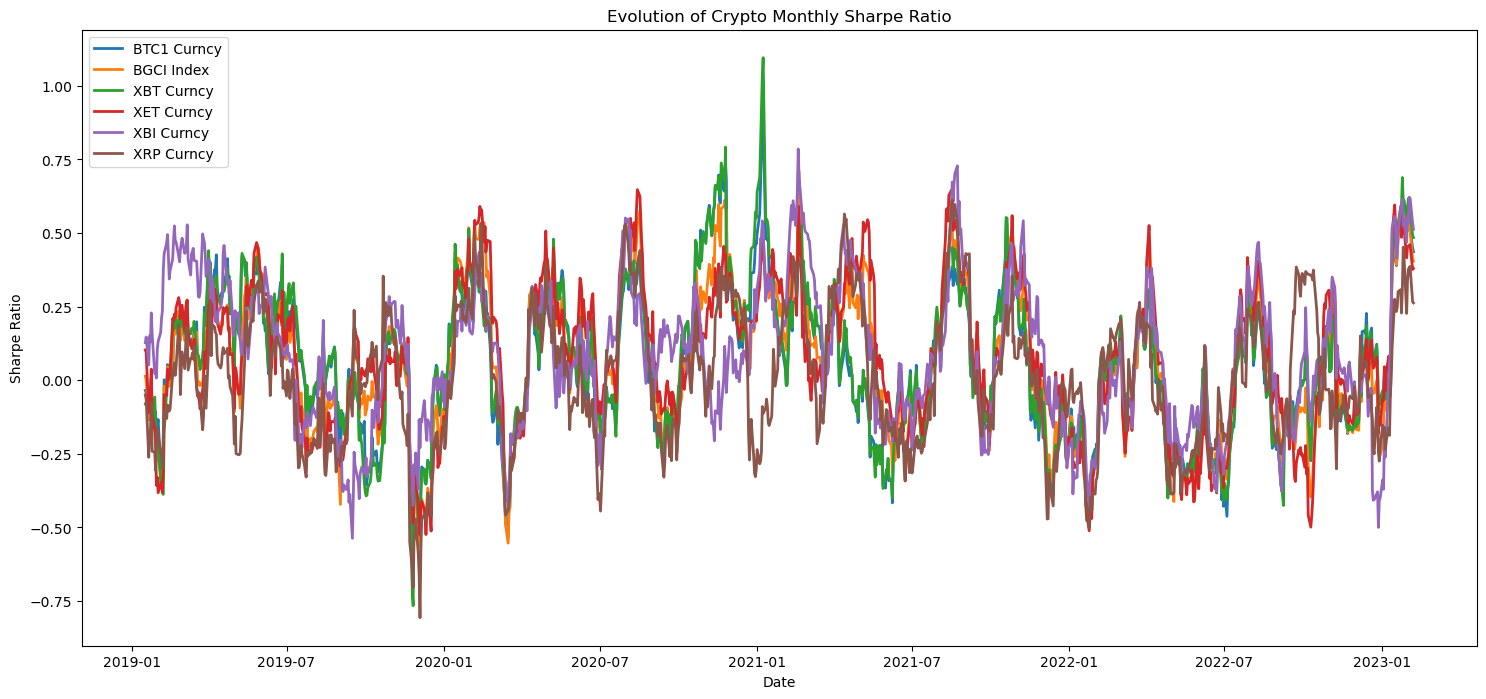

In [401]:
plot(rolling_sharpe_ratio, title='Evolution of Crypto Monthly Sharpe Ratio', y_label='Sharpe Ratio')

In [402]:
rolling_sharpe_ratio = calculate_rolling_parameter(market_returns, 20, calculate_sharpe_ratio)

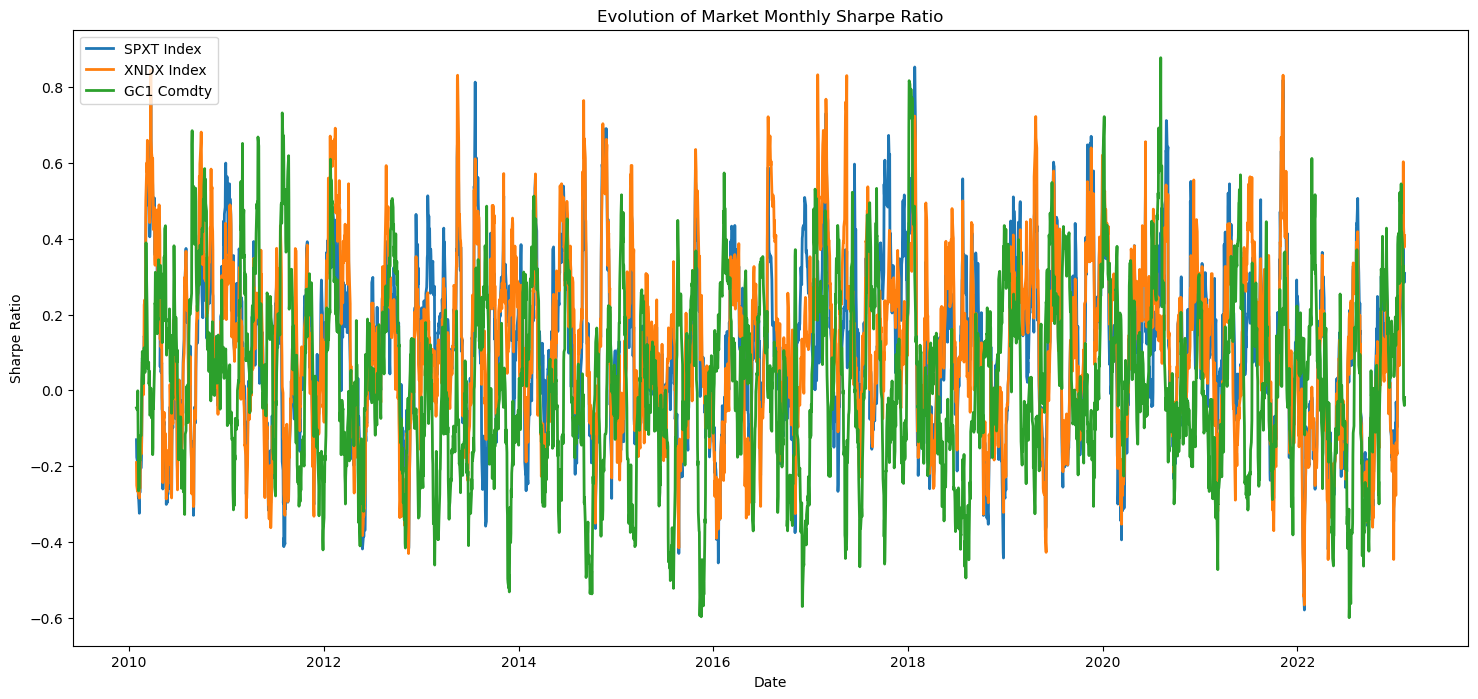

In [403]:
plot(rolling_sharpe_ratio, title='Evolution of Market Monthly Sharpe Ratio', y_label='Sharpe Ratio')

In [404]:
def calculate_drawdown(returns, window):
    drawdown = returns.rolling(window=window).apply(lambda val: ((val - val.cummax()) / val.cummax()).min())
    drawdown.replace([np.NaN, np.nan, np.inf, -np.inf, -1], 0, inplace=True)
    return drawdown

In [405]:
drawdown = calculate_drawdown(crypto_returns, 20)

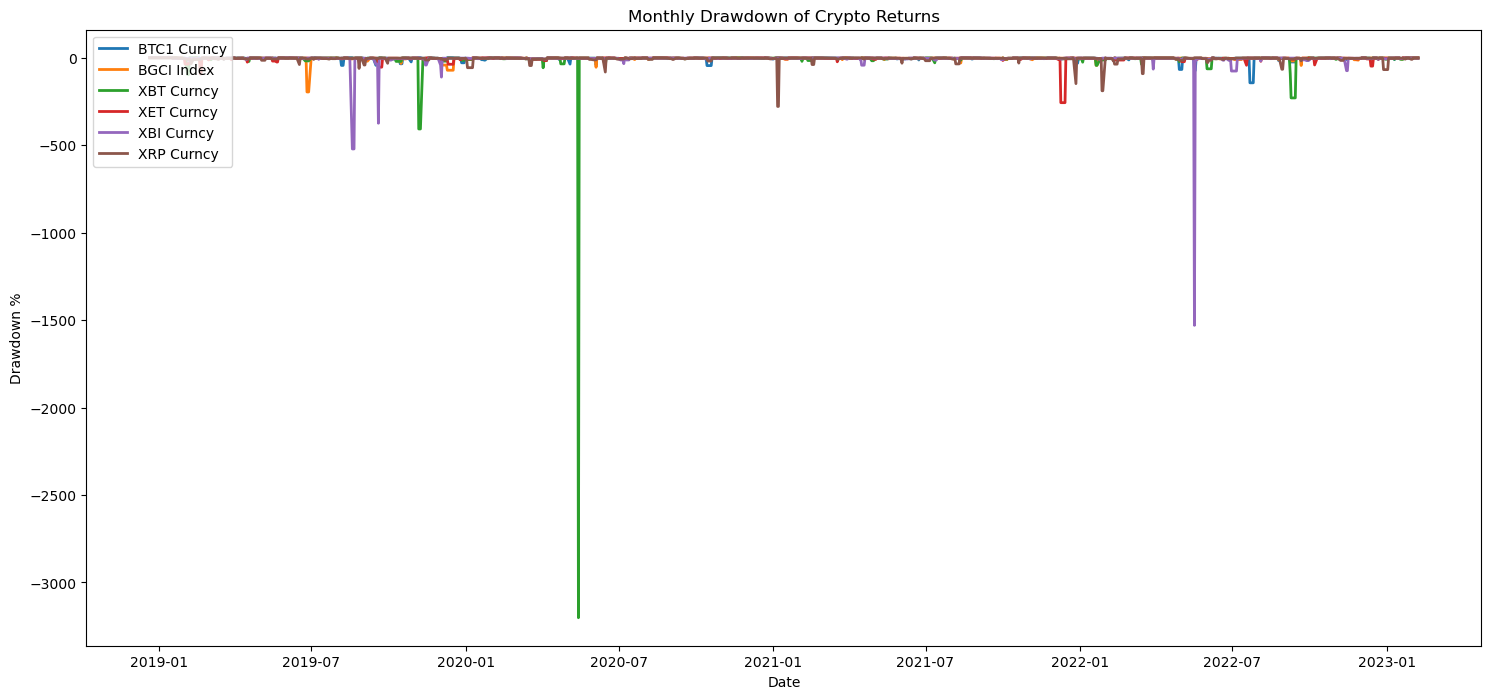

In [406]:
plot(drawdown, title='Monthly Drawdown of Crypto Returns', y_label='Drawdown %')

In [407]:
drawdown = calculate_drawdown(market_returns, 20)

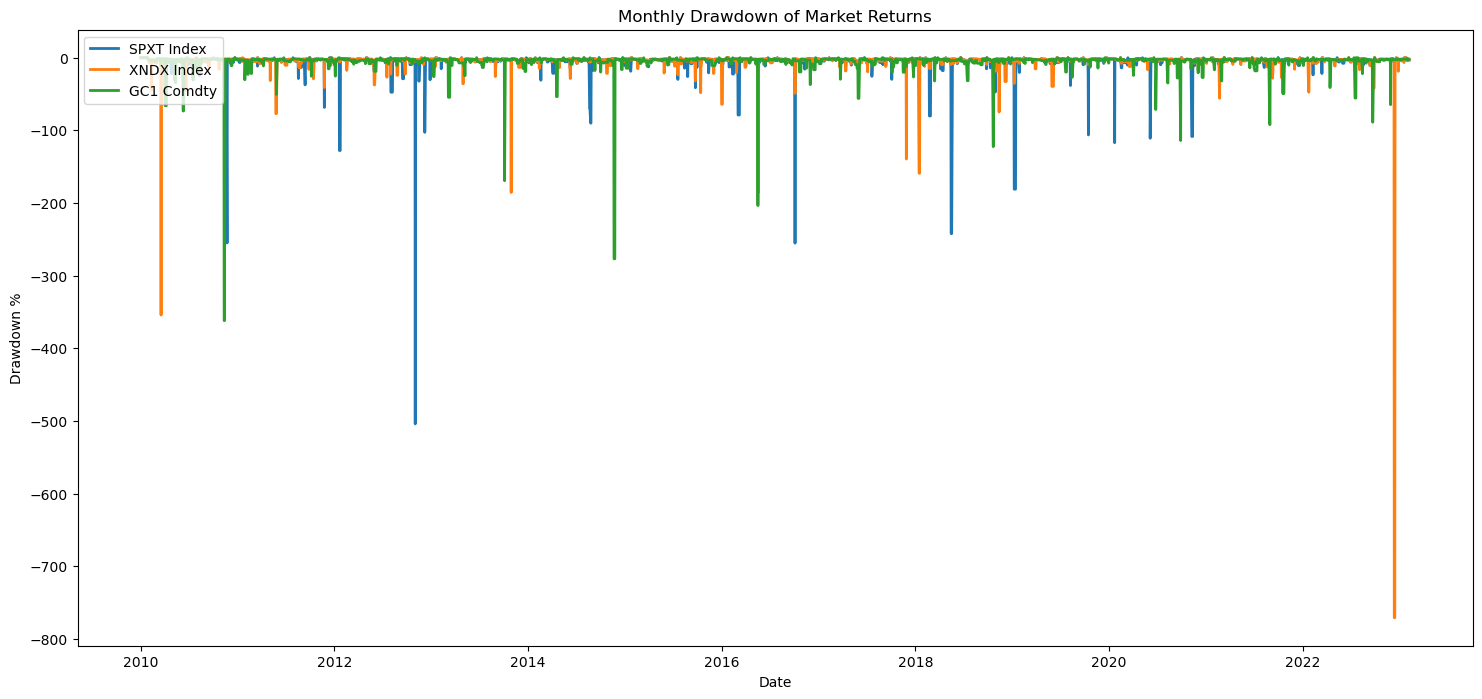

In [408]:
plot(drawdown, title='Monthly Drawdown of Market Returns', y_label='Drawdown %')

In [409]:
def compute_var(returns, alpha, window=None):
    var = np.percentile(returns, alpha)
    return var

In [410]:
def calculate_cvar(returns, window, period, alpha):
    cvar = returns.rolling(window).apply(lambda x: x[x<= compute_var(x, alpha)].mean()).dropna()
    cvar = cvar * np.sqrt(period)
    return cvar

In [411]:
crypto_cvar_95 = calculate_cvar(crypto_returns, 252, 1, 0.05)

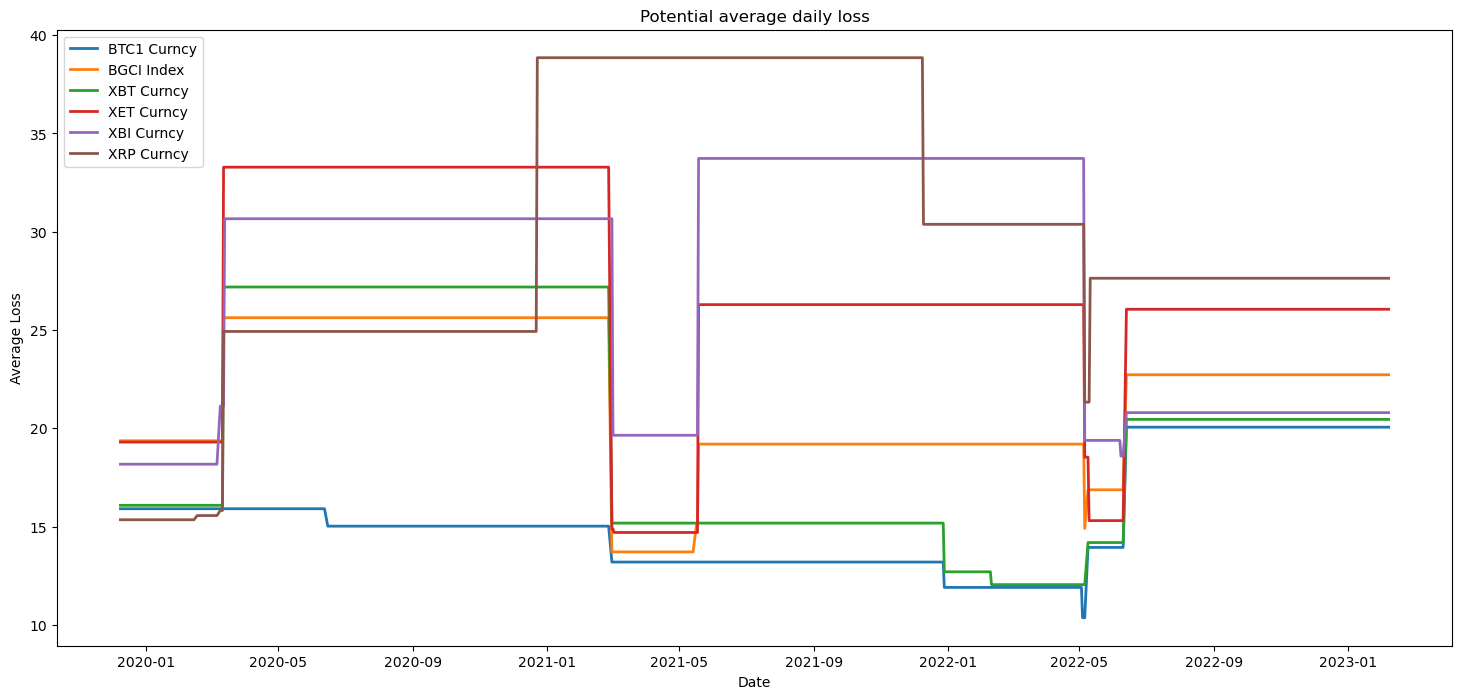

In [412]:
#Assuming a portfolio value of 100
plot(crypto_cvar_95* -100, title='Potential average daily loss', y_label='Average Loss')

In [413]:
market_cvar_95 = calculate_cvar(market_returns, 252, 1, 0.05)

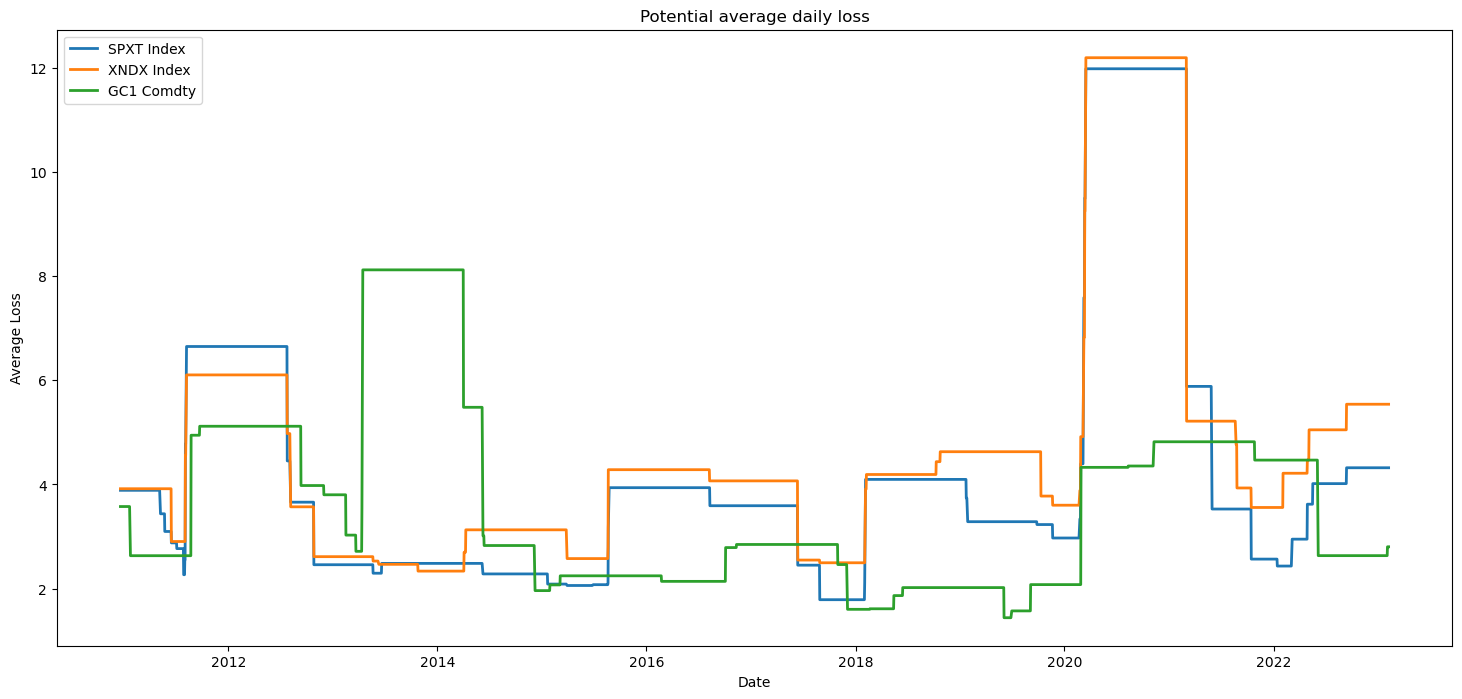

In [414]:
plot(market_cvar_95* -100, title='Potential average daily loss', y_label='Average Loss')

# *** Implementing Simple moving average strategy***

In [299]:
list_of_params = [{'window_long': 252, 'window_short': 8, 'allocation': .12},
                  {'window_long': 252, 'window_short': 20, 'allocation': .12},
                  {'window_long': 160, 'window_short': 10, 'allocation': .03},
                  {'window_long': 120, 'window_short': 10, 'allocation': .03},
                  {'window_long': 80, 'window_short': 5, 'allocation': .03},
                  {'window_long': 60, 'window_short': 2, 'allocation': .03}]

In [300]:
def calculate_moving_average(prices: DF, window_long: int, window_short: int, min_periods=None):
    long = prices.rolling(window_long, min_periods=min_periods).mean()
    short = prices.rolling(window_short, min_periods=min_periods).mean()
    signal = pd.DataFrame(index=prices.index, columns=prices.columns)
    signal[long >= short] = -1.
    signal[long <= short] = 1.
    signal.fillna(0., inplace=True)
    return signal

In [301]:
def create_signal(prices):
    signal = pd.DataFrame(index=prices.index, columns=prices.columns, data=0)
    for param in list_of_params:
        signal_tmp = calculate_moving_average(prices, param['window_long'], param['window_short'])
        signal_tmp = signal_tmp.mask(signal_tmp == 0).ffill()
        signal = signal + signal_tmp * param['allocation']
    return signal

In [302]:
def calculate_daily_weights(returns: DF, signal: DF, lookback_for_vol: int) -> DF:
    weights = get_inverse_vol_weights(returns, lookback_for_vol)
    weights = (weights * signal).fillna(0.0)
    return weights

In [303]:
def get_inverse_vol_weights(returns: DF, window: int = 252) -> DF:
    vol = returns.rolling(window=window).std()
    vol = vol[window:]
    _weights = 1 / vol
    _weights = _weights.replace([np.inf], np.NaN)
    _weights = _weights.div(_weights.sum(axis=1, skipna=True), axis=0)
    _weights.fillna(0, inplace=True)
    return _weights

In [332]:
signal = create_signal(crypto_prices)

In [333]:
weights = calculate_daily_weights(crypto_returns, signal, 252)

In [340]:
strategy_returns = crypto_returns.mul(weights, axis='index').sum(axis=1) * 100

In [339]:
cum_strategy_returns = calculate_cumulative_returns(strategy_returns)


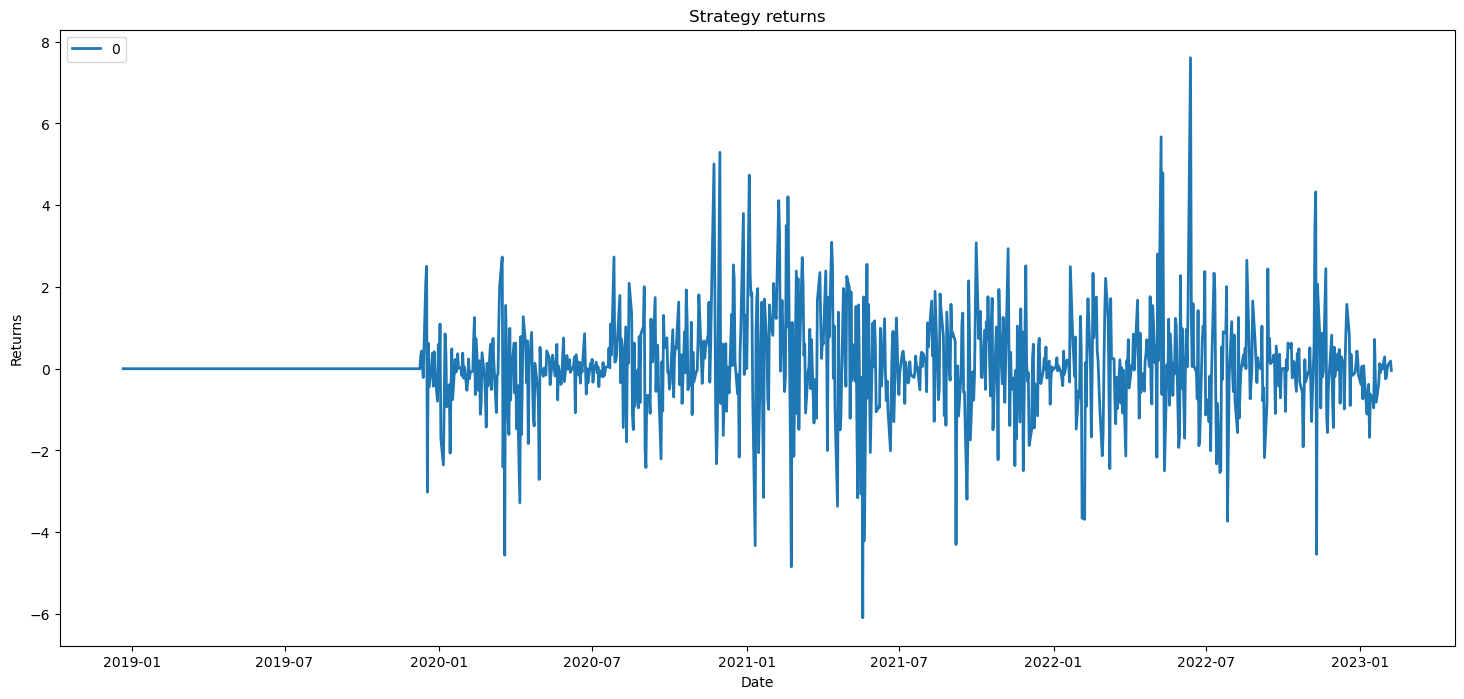

In [336]:
plot(strategy_returns.to_frame(), title='Strategy returns', y_label='Returns')